# Predicting the noise level of noisy FashionMNIST images

The goal is to predict the noise level of a noisy image so it can be passed into a pretrained diffusion model.

It seems like a very simple task given that general denoising models exist: if a general denoising model gives you an accurate denoised image, and the difference between the noisy and denoised image gives you the noise, if the noise added to each pixel is independent and has th same variance, then the variance of this predicted noise should give an accurate estimate. Therefore, I suspect the accuracy of a noise prediction model is limited by the accuracy of a denoising model, which means the accuracy of a noise predictor won't be very good at high noise levels but very accurate at low noise levels. Although, I doubt the accuracy of the predicted noise level at high noise levels matters that much for a diffusion model.


I start out with adding noise to images the way DDPM does it (variance-preserving), but there is code to do it the way EDM (Karras et al.) does it (variance-exploding) as well.

## Imports

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
os.environ['OMP_NUM_THREADS']='1'

In [2]:
#@title imports
from fastai.data.all import *
from fastai.vision.all import *
import k_diffusion as K
import torchvision.transforms as T
from torchvision import datasets
from datasets import load_dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


## Load dataset

Use 28x28 images, high batch size

In [3]:
sz = 28
bs = 2048
input_channels = 1
sample_n = 64
num_workers = 8

In [4]:
# EDM
# augment_prob = 0.12
# sigma_data = 0.6162
# mean = 0.2859
# std = 0.353
# sigma_min = 1e-2
# sigma_max = 80
# has_variance=True

# def make_sample_density(mean=-1.2, std=1.2):
#     #lognormal
#     return partial(K.utils.rand_log_normal, loc=mean, scale=std)

# class KarrasAugmentationPipelineCust(Transform):
#     def __init__(self):
#         self.pipeline = K.augmentation.KarrasAugmentationPipeline(augment_prob)
        
#     def encodes(self, image):
#         return self.pipeline(image)[0]

In [5]:
tfm = T.Compose([
    T.Resize(sz, interpolation=T.InterpolationMode.LANCZOS),
    T.CenterCrop(sz),
    #KarrasAugmentationPipelineCust() # EDM
])

Load from torchvision

In [6]:
dataset = datasets.FashionMNIST('data', train=True, download=True, transform=tfm)
print('Number of items in dataset:', len(dataset))

Number of items in dataset: 60000


Get noise schedule (DDPM)

In [7]:
betas = torch.linspace(0.0001, 0.02, 1000)
alphas = 1-betas
alpha_bar = torch.cumprod(alphas, dim=0)

Function that takes a batch and adds noise to it, with variance specified by the timestep `sigma_idx`:

In [8]:
def crappify_ddpm(input:TensorImage, sigma_idx):
    input = (input/255.)*2 - 1
    #sigma = torch.ones([input.shape[0]], device=device)*(sigmas_list[sigma_idx] + torch.randn([input.shape[0]], device=device))
    noise = torch.randn(input.shape)
    noised_input = torch.sqrt(alpha_bar[sigma_idx])*input + torch.sqrt(1-alpha_bar[sigma_idx])*noise
    #noised_input = scale_model_input(noised_input, sigma)
    noised_input = (255*(noised_input+1)/2)#.clamp(0, 255)
    return noised_input

In [9]:
# #EDM
# def get_scalings(sigma):
#     c_skip = sigma_data ** 2 / (sigma ** 2 + sigma_data ** 2)
#     c_out = sigma * sigma_data / (sigma ** 2 + sigma_data ** 2) ** 0.5
#     c_in = 1 / (sigma ** 2 + sigma_data ** 2) ** 0.5
#     return c_skip, c_out, c_in

# sample_density = make_sample_density()

# def scale_model_input(input, sigma):
#     _, _, c_in = [K.utils.append_dims(x, input.ndim) for x in get_scalings(sigma)]
#     input = input * c_in 
#     return input

# sigmas_list = K.sampling.get_sigmas_karras(1000, sigma_min, sigma_max, rho=7., device=device)

In [10]:
# def crappify_edm(input:TensorImage, sigma_idx):
#     input = (input/255.)*2 - 1
#     #sigma = torch.ones([input.shape[0]], device=device)*(sigmas_list[sigma_idx] + torch.randn([input.shape[0]], device=device))
#     sigma = sigmas_list[sigma_idx].cpu()
#     #print(sigma.shape)
#     #sigma = torch.rand([input.shape[0]], device=device) * (sigma_max - sigma_min) + sigma_min
#     #sigma = sample_density([input.shape[0]], device=device)
#     noise = torch.randn(input.shape) * K.utils.append_dims(sigma, input.ndim)
#     noised_input = input + noise
#     #noised_input = scale_model_input(noised_input, sigma)
#     noised_input = 255*(noised_input+1)/2
#     return noised_input

Create fastai DataLoader:

In [11]:
batch_tfms = []
batch_tfms.append(Normalize.from_stats(0.5, 0.5))

sigma_idx = torch.randint(low=0, high=len(betas)-1, size=(len(dataset),)) # random amounts of noise to add

# Dataloader
dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), RegressionBlock),
                   get_items=lambda x: range(len(dataset)),
                   get_x = lambda x: crappify_ddpm(tensor(dataset[x][0]).float(), sigma_idx=sigma_idx[x]), # create noisy images
                   get_y = lambda x: torch.sqrt(1-alpha_bar[sigma_idx[x]]), # label is the variance of the noise
                   batch_tfms=batch_tfms)
dls = dblock.dataloaders('', bs=bs)

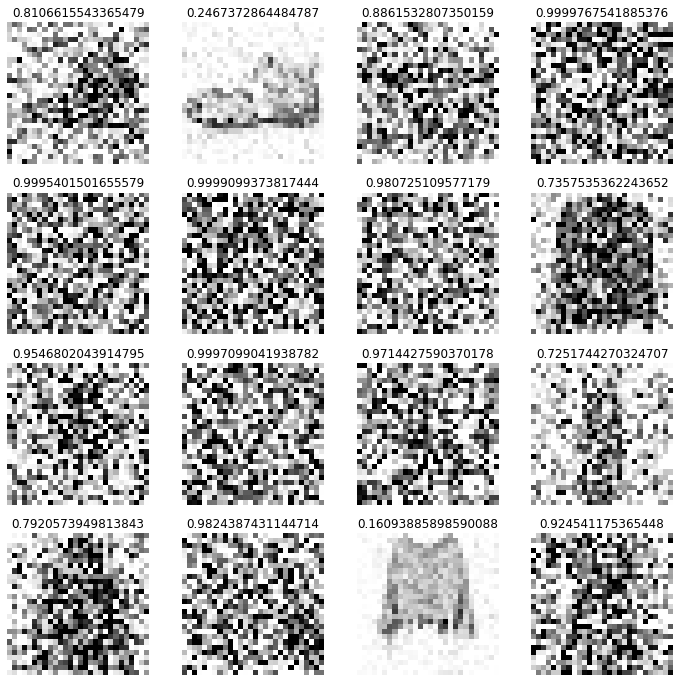

In [12]:
dls.show_batch(max_n=16)

## Training - unsuccessful approach

We will train a model to take a noisy image and output the variance of the noise. It will be trained with an MSE loss and evaluated with RMSE. Let's first create a dummy neural network to figure out what's the best score you get when you just predict the mean, which we calculate:

In [13]:
torch.sqrt(1-alpha_bar[sigma_idx]).mean()

tensor(0.8051)

In [14]:
class f(nn.Module):
    def __init__(self):
        super().__init__()
        self.blah = nn.Linear(1,1)
    def forward(self,x): 
        y =  0.8072*torch.ones((x.shape[0],)).cuda()
        return y

In [15]:
learn = Learner(dls, f(), metrics=[rmse], loss_func=nn.MSELoss())

In [16]:
learn.validate()

(#2) [0.0749579593539238,0.2737845182418823]

So if it's just predicting the mean, we get an MSE loss of ~0.075 and and RMSE (just the sqrt of the MSE) of ~0.274. We should at least get metrics better than this.

Let's create our regular Learner then. We'll train a ResNet (with a bag of tricks) from scratch. It will take in 1 channel (working with grayscale images) and output 1 value. We'll keep track of activation statistics as well.

In [17]:
learn = Learner(dls, xresnet34(c_in=1, n_out=1), metrics=[rmse], loss_func=nn.MSELoss(), cbs=[ActivationStats(every=10,with_hist=True)])

/home/tmabraham/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


/home/tmabraham/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/_tensor.py:1051: UserWarning: Using a target size (torch.Size([2048])) that is different to the input size (torch.Size([2048, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret = func(*args, **kwargs)


SuggestedLRs(valley=0.0003981071640737355)

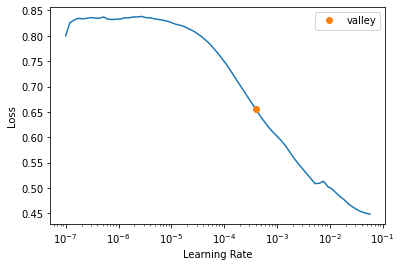

In [18]:
learn.lr_find()

In [19]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,_rmse,time
0,0.371117,0.199999,0.516475,00:18
1,0.206854,0.097725,0.383465,00:15
2,0.145268,0.082459,0.262813,00:15
3,0.115540,0.077536,0.266720,00:18
4,0.099729,0.076902,0.268820,00:14


/home/tmabraham/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/_tensor.py:1051: UserWarning: Using a target size (torch.Size([1760])) that is different to the input size (torch.Size([1760, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret = func(*args, **kwargs)


This model isn't any better than predicting the mean! The activation statistics are a little wonky but the one at the last layer also demonstrates the model itself is just predicting the mean of the dataset.

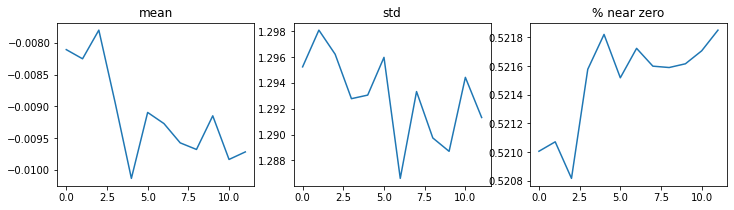

In [20]:
learn.activation_stats.plot_layer_stats(0)

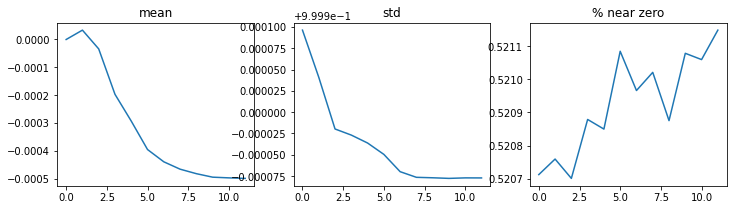

In [21]:
learn.activation_stats.plot_layer_stats(1)

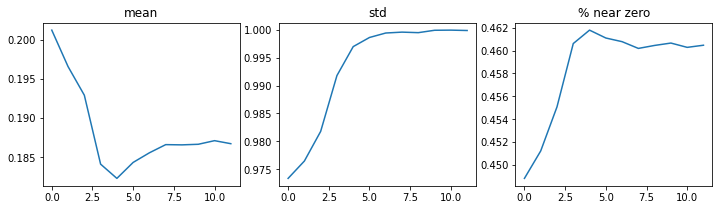

In [22]:
learn.activation_stats.plot_layer_stats(2)

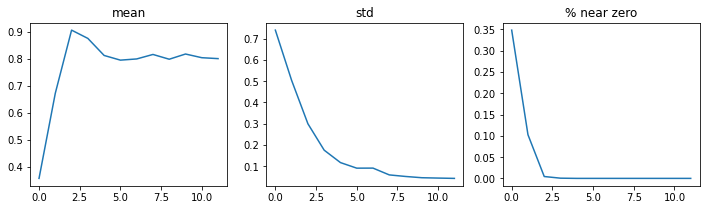

In [23]:
learn.activation_stats.plot_layer_stats(-1)

It can be seen it's predicting mostly between 0.75-0.85:

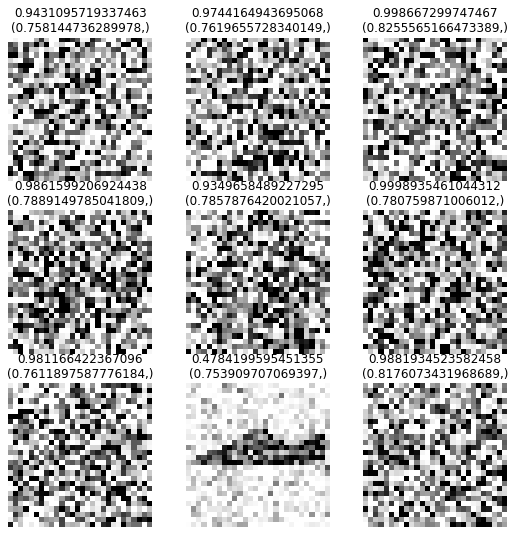

In [24]:
learn.show_results()

Similar results are obtained with predicting the timestep `sigma_idx` instead of the noise variance itself.

## Training - successful approach

An alternative approach seems to be more successful: treat the task as a classification problem, predicting which of the 1000 timesteps the image has. Of course, this isn't very general, not allowing for continuous prediction of noise variance. But this is what works for the time being 🤷‍♂️

We need to recreate the DataLoaders:

In [36]:
batch_tfms = []
batch_tfms.append(Normalize.from_stats(0.5, 0.5))

sigma_idx = torch.randint(low=0, high=len(betas)-1, size=(len(dataset),)) # random amounts of noise to add

# Dataloader
dblock = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), # change to CategoryBlock
                   get_items=lambda x: range(len(dataset)),
                   get_x = lambda x: crappify_ddpm(tensor(dataset[x][0]).float(), sigma_idx=sigma_idx[x]), # create noisy images
                   get_y = lambda x: sigma_idx[x].item(), # label is now the timestep
                   batch_tfms=batch_tfms)
dls = dblock.dataloaders('', bs=bs)

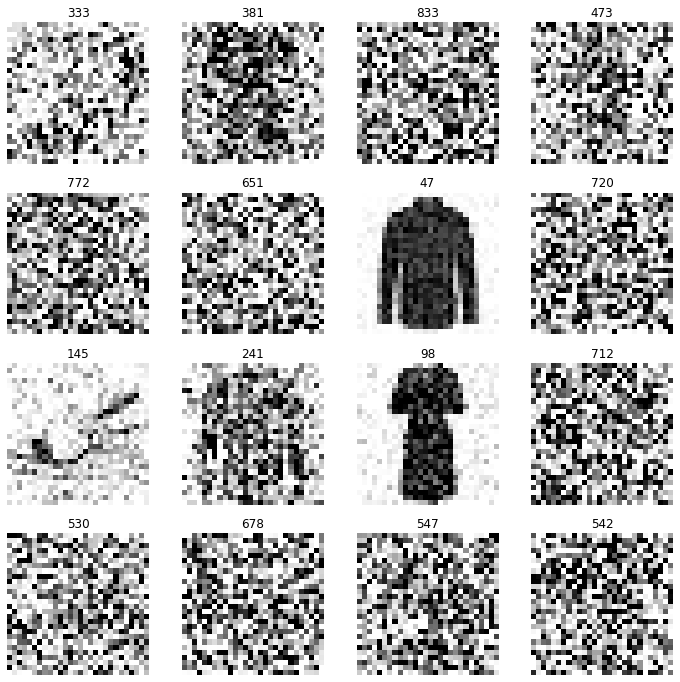

In [37]:
dls.show_batch(max_n=16)

Again, let's come up with a "predicting the mean" baseline:

In [38]:
class f(nn.Module):
    def __init__(self):
        super().__init__()
        self.blah = nn.Linear(1,1)
    def forward(self,x): 
        y = torch.zeros((x.shape[0],1000)).cuda()        
        y[:, 499] = 1
        return y

Since we are doing classification, the RMSE metric won't work out-of-the=box. Let's write our own:

In [39]:
def test_rmse(inp,targ):
    pred,targ = flatten_check(inp.argmax(dim=-1), targ)
    return rmse(pred.float(),targ.float())

In [40]:
learn = Learner(dls, f(), metrics=[accuracy,test_rmse])

In [41]:
learn.validate()

(#3) [6.908724784851074,0.000750000006519258,288.1048889160156]

The model gets a cross entropy of ~6.9, accuracy of 0.00075, and an RMSE of 288. This is what we need to beat.

Let's create our proper Learner and train:

In [42]:
learn = Learner(dls, xresnet34(c_in=1, n_out=1000), opt_func=ranger, metrics=[accuracy,test_rmse])

SuggestedLRs(valley=0.002511886414140463)

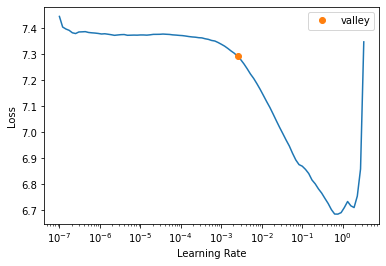

In [43]:
learn.lr_find()

In [44]:
learn.fit_one_cycle(10,3e-2)

epoch,train_loss,valid_loss,accuracy,test_rmse,time
0,7.004849,8.915194,0.002250,284.807098,00:08
1,6.356437,6.766108,0.004417,160.240189,00:08
2,5.995567,7.035171,0.003833,180.484085,00:08
3,5.754251,6.138407,0.007417,145.849548,00:07
4,5.569630,5.246924,0.013083,90.170158,00:07
5,5.452191,5.403915,0.013417,128.633591,00:09
6,5.327836,5.251719,0.013417,77.159744,00:08
7,5.216707,5.010897,0.017333,85.344971,00:08
8,5.123080,4.952533,0.023417,87.222260,00:08
9,5.054106,4.947990,0.022583,88.344208,00:08


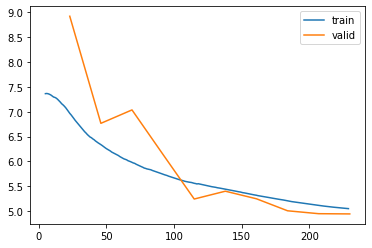

In [45]:
learn.recorder.plot_loss()

You can see while it is not exact (although it happens once-in-a-while), it's fairly close, and it's not predicting one value.

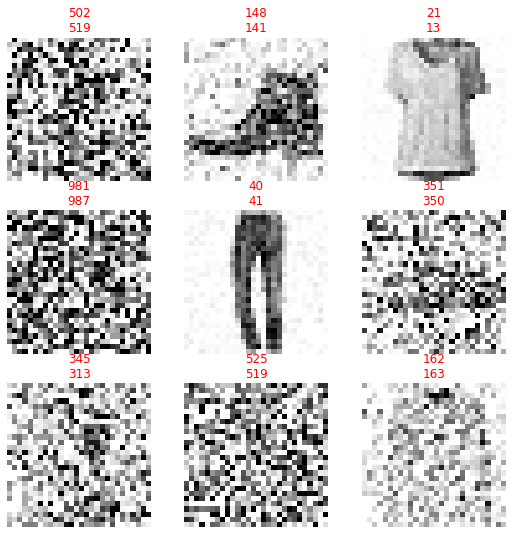

In [46]:
learn.show_results()